# Museum Analytics: Visitor-Population Correlation Analysis

This notebook demonstrates the analysis of museum visitor data and its correlation with city population using linear regression.

In [15]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Add the src directory to the path
sys.path.append('/workspace/museum_analytics/src')

# Import our custom modules
from data_extraction.wikipedia_scraper import WikipediaMuseumScraper
from data_extraction.population_data import PopulationDataExtractor
from data_processing.harmonizer import DataHarmonizer
from models.regression_model import MuseumRegressionModel
from database.db_manager import DatabaseManager

print("Libraries imported successfully!")

Libraries imported successfully!


In [16]:
# Extract museum data from Wikipedia
print("Extracting museum data from Wikipedia...")
museum_scraper = WikipediaMuseumScraper()
museums = museum_scraper.extract_museum_data()

if museums:
    museum_df = museum_scraper.save_to_csv(museums, "/workspace/data/museum_data.csv")
    print(f"Successfully extracted {len(museums)} museums")
    print("\nSample museum data:")
    print(museum_df.head())
else:
    print("Failed to extract museum data")

Extracting museum data from Wikipedia...


INFO:data_extraction.wikipedia_scraper:Extracted (table): Louvre in Paris - 8,700,000 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): National Museum of China in Beijing - 6,956,800 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): Vatican Museums in Vatican City,Rome - 6,825,436 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): British Museum in London - 6,479,952 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): Natural History Museum, South Kensington in London - 6,301,972 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): Metropolitan Museum of Art in New York City - 5,727,258 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): American Museum of Natural History in New York City - 5,400,000 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): China Science and Technology Museum in Beijing - 5,315,000 visitors
INFO:data_extraction.wikipedia_scraper:Extracted (table): Na

Successfully extracted 53 museums

Sample museum data:
                                museum_name               city  \
0                                    Louvre              Paris   
1                  National Museum of China            Beijing   
2                           Vatican Museums  Vatican City,Rome   
3                            British Museum             London   
4  Natural History Museum, South Kensington             London   

   annual_visitors         country    year  
0          8700000          France  2024.0  
1          6956800           China  2024.0  
2          6825436    Vatican City  2024.0  
3          6479952  United Kingdom  2024.0  
4          6301972  United Kingdom  2024.0  


In [17]:
# Extract population data
print("Extracting city population data...")
population_extractor = PopulationDataExtractor()

if museums:
    unique_cities = list(set([museum['city'] for museum in museums]))
    population_data = population_extractor.get_city_population_data(unique_cities)
    
    if population_data:
        population_df = population_extractor.save_to_csv(population_data, "/workspace/data/city_population.csv")
        print(f"Successfully extracted population data for {len(population_data)} cities")
        print("\nSample population data:")
        print(population_df.head())
    else:
        print("Failed to extract population data")
else:
    print("No museum data available for population extraction")

INFO:data_extraction.population_data:Added major city data: Madrid - 6,700,000
INFO:data_extraction.population_data:Added major city data: London - 9,000,000
INFO:data_extraction.population_data:Added major city data: Beijing - 21,500,000
INFO:data_extraction.population_data:Added major city data: Sydney - 5,300,000
INFO:data_extraction.population_data:Added major city data: Tokyo - 14,000,000
INFO:data_extraction.population_data:Added major city data: Warsaw - 1,800,000
INFO:data_extraction.population_data:Added major city data: Moscow - 12,500,000
INFO:data_extraction.population_data:Added major city data: Berlin - 3,700,000
INFO:data_extraction.population_data:Added major city data: Amsterdam - 1,200,000
INFO:data_extraction.population_data:Added major city data: Paris - 11,000,000
INFO:data_extraction.population_data:Added major city data: Mexico City - 9,200,000
INFO:data_extraction.population_data:Saved 11 cities to /workspace/data/city_population.csv


Extracting city population data...
Successfully extracted population data for 11 cities

Sample population data:
      city  population
0   Madrid     6700000
1   London     9000000
2  Beijing    21500000
3   Sydney     5300000
4    Tokyo    14000000


In [18]:
# Harmonize the data
print("Harmonizing museum and population data...")
harmonizer = DataHarmonizer("/workspace/data/museum_analytics.db")
harmonized_df = harmonizer.harmonize_data("/workspace/data/museum_data.csv", "/workspace/data/city_population.csv")

if not harmonized_df.empty:
    print(f"Successfully harmonized {len(harmonized_df)} museum records")
    print("\nSample harmonized data:")
    print(harmonized_df.head())
else:
    print("Failed to harmonize data")

INFO:data_processing.harmonizer:Starting data harmonization process
INFO:data_processing.harmonizer:Loaded 53 museum records from /workspace/data/museum_data.csv
INFO:data_processing.harmonizer:Loaded 11 city records from /workspace/data/city_population.csv
INFO:data_processing.harmonizer:Successfully matched 53 museum records


Harmonizing museum and population data...


INFO:data_processing.harmonizer:Connected to database: /workspace/data/museum_analytics.db
INFO:data_processing.harmonizer:Database tables created successfully
INFO:data_processing.harmonizer:Saved 53 records to museums table
INFO:data_processing.harmonizer:Saved 11 records to cities table
INFO:data_processing.harmonizer:Saved 53 records to harmonized_data table
INFO:data_processing.harmonizer:Saved harmonized data to /workspace/data/harmonized_museum_data.csv
INFO:data_processing.harmonizer:Database connection closed


Successfully harmonized 53 museum records

Sample harmonized data:
                                museum_name        city_museum  \
0                                    Louvre              Paris   
1                  National Museum of China            Beijing   
2                           Vatican Museums  Vatican City,Rome   
3                            British Museum             London   
4  Natural History Museum, South Kensington             London   

   annual_visitors         country    year city_pop  population  \
0          8700000          France  2024.0    Paris  11000000.0   
1          6956800           China  2024.0  Beijing  21500000.0   
2          6825436    Vatican City  2024.0      NaN         NaN   
3          6479952  United Kingdom  2024.0   London   9000000.0   
4          6301972  United Kingdom  2024.0   London   9000000.0   

   visitor_population_ratio  
0                  0.790909  
1                  0.323572  
2                       NaN  
3            

In [19]:
# Train the regression model
if not harmonized_df.empty:
    print("Training linear regression model...")
    model = MuseumRegressionModel("/workspace/models/museum_regression_model.pkl")
    
    # Train the model
    metrics = model.train("/workspace/data/harmonized_museum_data.csv")
    
    if 'error' not in metrics:
        print("\nModel Training Results:")
        print(f"Training R²: {metrics['train_r2']:.4f}")
        print(f"Test R²: {metrics['test_r2']:.4f}")
        print(f"Correlation: {metrics['correlation']:.4f}")
        print(f"Training MSE: {metrics['train_mse']:,.2f}")
        print(f"Test MSE: {metrics['test_mse']:,.2f}")
        
        # Get model summary
        summary = model.get_model_summary()
        if 'equation' in summary:
            print(f"\nModel Equation: {summary['equation']}")
        elif 'approx_equation_original_space' in summary:
            print(f"\n{summary['equation_log_space']}")
            print(f"Approx. original-space: {summary['approx_equation_original_space']}")
        else:
            print("\nNo equation available. Summary keys:", list(summary.keys()))

    else:
        print(f"Error training model: {metrics['error']}")
else:
    print("No data available for model training")

INFO:models.regression_model:Starting model training
INFO:models.regression_model:Loaded 53 records from /workspace/data/harmonized_museum_data.csv
INFO:models.regression_model:Renamed 'population' -> 'city_population'
INFO:models.regression_model:Removed 32 rows with missing data
INFO:models.regression_model:Outlier removal disabled; using 21 records
INFO:models.regression_model:Applied log1p transform to features and target
INFO:models.regression_model:Model training completed. Test R²: 0.0894, Correlation: 0.5274
INFO:models.regression_model:Model saved to /workspace/models/museum_regression_model.pkl


Training linear regression model...

Model Training Results:
Training R²: 0.2782
Test R²: 0.0894
Correlation: 0.5274
Training MSE: 1,538,570,214,209.53
Test MSE: 7,097,708,750,796.04

log1p(visitors) = 0.195215 * z_scaled + 15.010216
Approx. original-space: visitors ≈ 0.0017 * population + 31863.67


Creating visualizations...


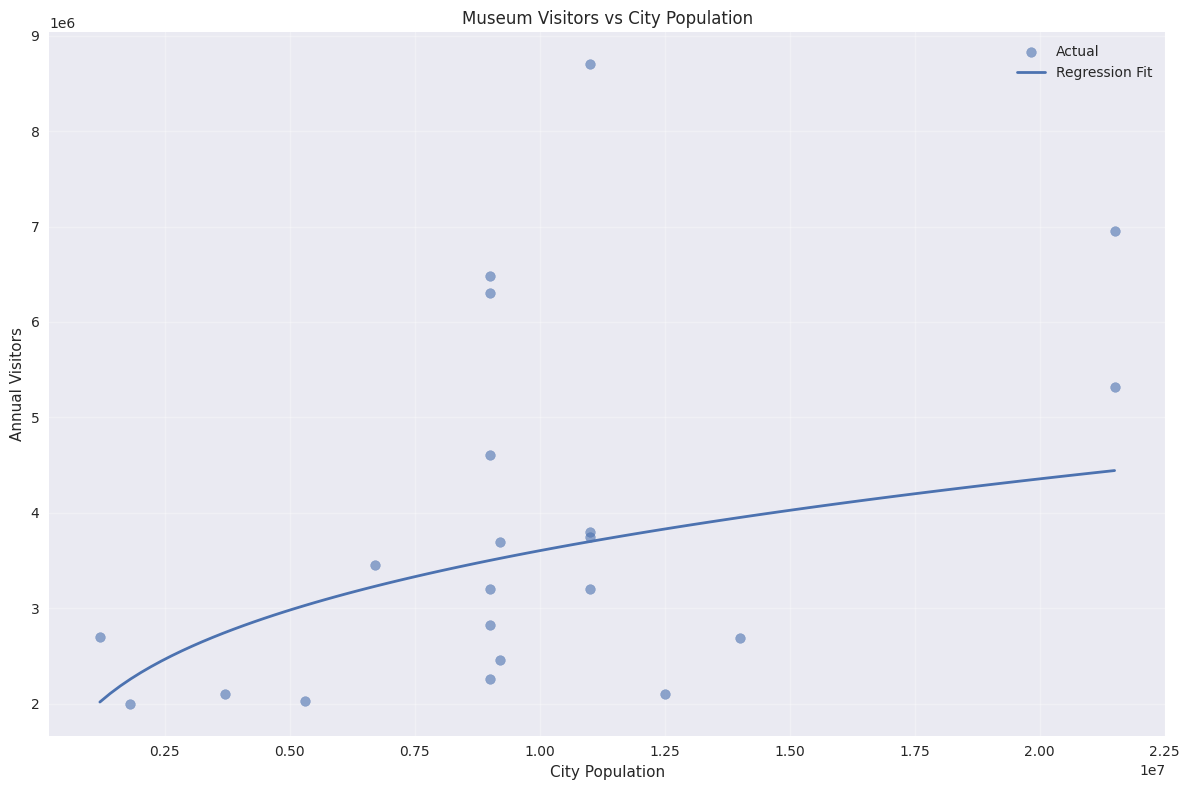

INFO:models.regression_model:Loaded 53 records from /workspace/data/harmonized_museum_data.csv
INFO:models.regression_model:Renamed 'population' -> 'city_population'
INFO:models.regression_model:Removed 32 rows with missing data
INFO:models.regression_model:Outlier removal disabled; using 21 records
INFO:models.regression_model:Applied log1p transform to features and target
INFO:models.regression_model:Visualizations saved to /workspace/plots/


Visualizations saved to '/workspace/plots/' directory


In [20]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths inside the container
HARMONIZED = Path("/workspace/data/harmonized_museum_data.csv")
PLOTS_DIR  = Path("/workspace/plots")

if not harmonized_df.empty and 'error' not in metrics:
    print("Creating visualizations...")

    # Load data
    df = pd.read_csv(HARMONIZED)

    # --- Resolve population column alias ---
    pop_col = None
    for cand in ['city_population', 'population', 'city_pop']:
        if cand in df.columns:
            pop_col = cand
            break
    if pop_col is None:
        raise KeyError(f"No population column found. Columns: {list(df.columns)}")

    # Clean data
    df_clean = df.dropna(subset=[pop_col, 'annual_visitors']).copy()

    # Scatter
    plt.figure(figsize=(12, 8))
    plt.scatter(df_clean[pop_col], df_clean['annual_visitors'],
                alpha=0.6, label='Actual')

    # Regression line (model.predict is scalar → vectorize)
    x_min = df_clean[pop_col].min()
    x_max = df_clean[pop_col].max()
    X_line = np.linspace(x_min, x_max, 100)
    y_line = np.array([model.predict(float(x)) for x in X_line])

    plt.plot(X_line, y_line, linewidth=2, label='Regression Fit')
    plt.xlabel('City Population')
    plt.ylabel('Annual Visitors')
    plt.title('Museum Visitors vs City Population')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Also create the built-in set of plots (handles log transforms)
    model.create_visualizations(str(HARMONIZED), str(PLOTS_DIR))
    print(f"Visualizations saved to '{PLOTS_DIR}/' directory")
else:
    print("No model available for visualization")


In [21]:
# Test model predictions
if not harmonized_df.empty and 'error' not in metrics:
    print("Model Predictions for Different City Sizes:")
    print("=" * 50)
    
    test_cities = [
        (100_000, "Small City"),
        (500_000, "Medium City"),
        (1_000_000, "Large City"),
        (5_000_000, "Metropolitan Area"),
        (10_000_000, "Mega City")
    ]
    
    for population, city_type in test_cities:
        prediction = model.predict(population)
        print(f"{city_type} ({population:,} people): {prediction:,.0f} predicted visitors")
    
    print("\n" + "=" * 50)
    print("Note: These are predictions based on city population only.")
    print("Actual museum attendance depends on many other factors.")
else:
    print("No trained model available for predictions")

Model Predictions for Different City Sizes:
Small City (100,000 people): 1,022,658 predicted visitors
Medium City (500,000 people): 1,588,244 predicted visitors
Large City (1,000,000 people): 1,919,806 predicted visitors
Metropolitan Area (5,000,000 people): 2,981,570 predicted visitors
Mega City (10,000,000 people): 3,604,003 predicted visitors

Note: These are predictions based on city population only.
Actual museum attendance depends on many other factors.
